In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.preprocessing.image import load_img, img_to_array
target_image_path = '/content/drive/My Drive/Colab Notebooks/img/cat.jpg'
style_reference_image_path = '/content/drive/My Drive/Colab Notebooks/img/chinese_2.jpg'
width, height = load_img(target_image_path).size
img_height = 512
img_width = int(width * img_height / height)

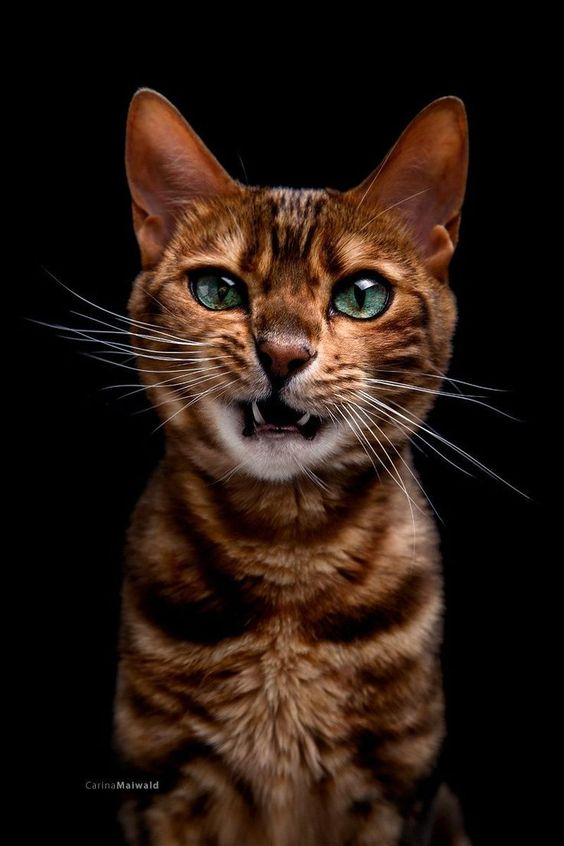

In [21]:
from IPython.display import Image

Image(target_image_path)

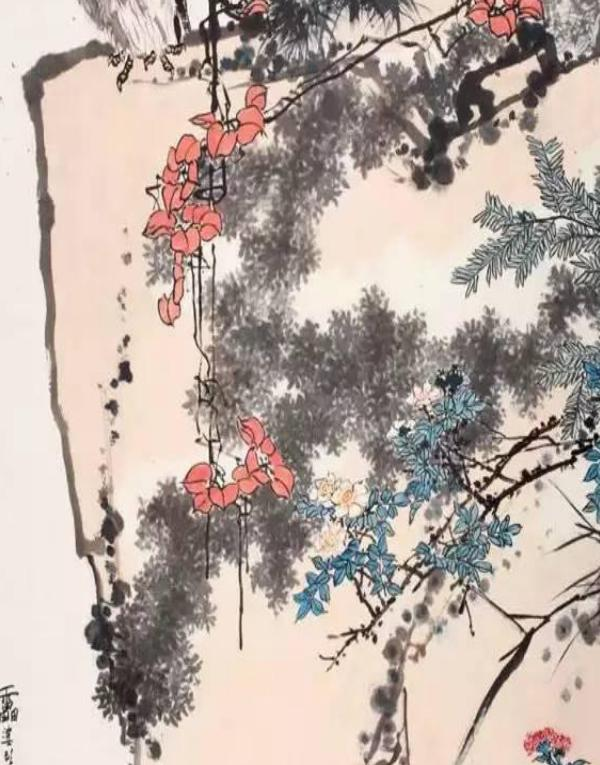

In [22]:
Image(style_reference_image_path)

In [0]:
import numpy as np
from keras.applications import vgg19
def preprocess_image(image_path):
  img = load_img(image_path, target_size=(img_height, img_width))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

In [0]:
def deprocess_image(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [25]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))
input_tensor = K.concatenate([target_image,style_reference_image,combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet',include_top=False)
print('Model loaded.')

Model loaded.


In [0]:
def content_loss(base, combination):
  return K.sum(K.square(combination - base))

def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.sum(K.square(S - C)) / (4 * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
  a = K.square(
  x[:, :img_height - 1, :img_width - 1, :] -
  x[:, 1:, :img_width - 1, :])
  b = K.square(
  x[:, :img_height - 1, :img_width - 1, :] -
  x[:, :img_height - 1, 1:, :])
  return K.sum(K.pow(a + b, 1.25))

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block4_conv2'
style_layers = ['block5_conv1',
                'block4_conv1',
                'block3_conv1',
                'block2_conv1',
                'block1_conv1']
total_variation_weight = 5
style_weight = 10000
content_weight = 0.05

In [34]:
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,combination_features)

In [0]:
for layer_name in style_layers:
  layer_features = outputs_dict[layer_name]
  style_reference_features = layer_features[1, :, :, :]
  combination_features = layer_features[2, :, :, :]
  sl = style_loss(style_reference_features, combination_features)
  loss += (style_weight / len(style_layers)) * sl
  
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])
class Evaluator(object):
  def __init__(self):
    self.loss_value = None
    self.grads_values = None
    
  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values
    
evaluator = Evaluator()


In [37]:
from scipy.optimize import fmin_l_bfgs_b
#from scipy.misc import imsave
import time
import IPython.display as display
import PIL.Image


result_prefix = 'my_result'
iterations = 50
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss,x,fprime=evaluator.grads,maxfun=20)
  print('Current loss value:', min_val)
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  display.display(PIL.Image.fromarray(img))
  #print('Image saved as', fname)
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

Output hidden; open in https://colab.research.google.com to view.

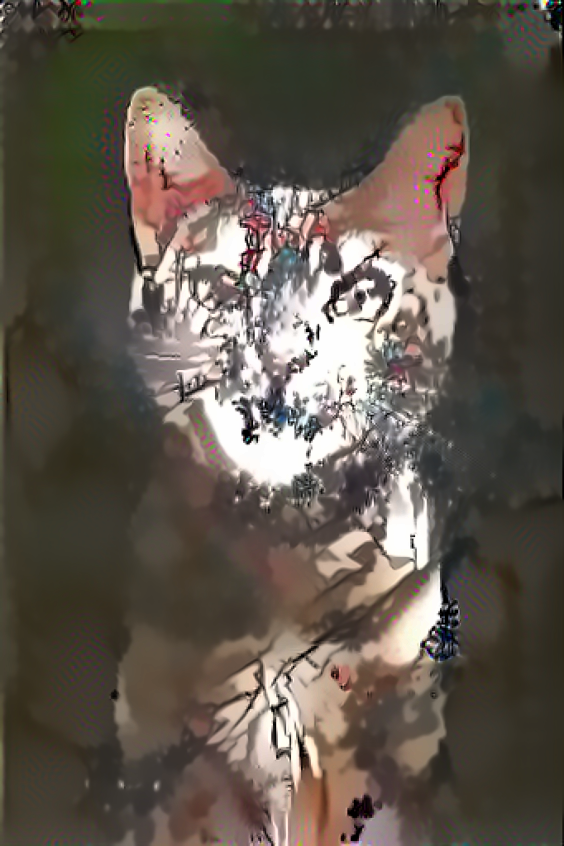

In [39]:
import matplotlib.pyplot as plt
import cv2 as cv
# save the image
x = cv.resize(img, (width, height), interpolation = cv.INTER_AREA)
x = cv.fastNlMeansDenoisingColored(x,None,10,10,7,21)
display.display( PIL.Image.fromarray(x))

In [0]:
plt.imsave('/content/drive/My Drive/Colab Notebooks/img/FastNST_img/NST01_cattest.png', x)